In [1]:
import kwant
import numpy as np
from math import pi
from cmath import exp
import matplotlib.pyplot as plt     
from matplotlib import cm, colors
from IPython import display
import pandas as pd
import imageio


/Users/guilhermedelfino/opt/anaconda3/lib/python3.9/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:
def label_plot(phi_ar):
    lab_size=int(np.array(phi_ar).shape[0])
    out=[]
    out_phi=[]
    print(lab_size)
    spacing=int(lab_size/6)
    for j in range(0,6):
        out.append(int(spacing*j))
        out_phi.append(round(phi_ar[int(spacing*j)],2))
    return out, out_phi

def label_ploty(delta_ar):
    lab_size=int(np.array(delta_ar).shape[0])
    out=[]
    out_phi=[]
    # print(lab_size)
    spacing=int(lab_size/5)
    for j in range(0,6):
        out.append(int(spacing*j))
        out_phi.append(delta_ar[int(spacing*j)])
    return out, out_phi


In [3]:
def on_triangle_edges(position, L, W):
    #L lenght of triangle edge
    #W width of triangle edge
    #position (i,j)
    #output: true or false if position belongs to the edge of the triangle

    x, y = position  # Get site coordinates
    
    # Edge 1: Bottom horizontal (-W <= y <= 0)
    if -W<= y <=0 and -W <= x <= L+W:
        return  True #False# True
    
    # Edge 2: Left slope (-W <= x <= 0, and 0 <= y<= L)
    if -W <= x <= 0 and (-W <= y and y+x<= L+W):
        return True
    
    # Edge 3: Right slope (x=L and 0<y<L)
    if L <= x+y <= L+W and -W <= y <= L+W:
        return True# False #True

    return False


def check_phase(position, L,W):
    mid=int(L/2)
    x, y = position 
    ans=0

     # theta1: upper part    #upper left or upper right  (mid <= y and mid<y+x<= L+W))
    if (-W <= x <= 0 and (mid < y+x<= L+W)) or (L <= x+y <= L+W and mid < y <= L+W):
        ans=1
    
    # # theta2: Left part   #lower left or left bottom
    if (-W <= x <= 0 and (-W <= y and y+x<= mid)) or (-W<= y <=0 and -W <= x <= mid):
        ans= 2
    
    # theta3: Right lower  or lower right
    if (-W <= y <=0 and mid < x <= L+W) or (L <= x+y <= L+W and -W <= y <= mid):
        ans= 3
    
    return ans


def flux_hopping(site1, site2, phi, gamma):
    return [[-gamma * exp(1j * phi / 3), 0], [0, gamma * exp(-1j * phi / 3)]]


def build_system(phi,delta, gamma,  theta1, theta2, theta3,L,W):
    a = 1
    t = 1.0
    r=0

    syst = kwant.Builder()
    lat = kwant.lattice.triangular(a, norbs=2)


    for i in range(-W, L+2*W+1):
        for j in range(-W, L+2*W+1):
            position = (i,j)
            indicator = check_phase(position, L,W)
                

            if on_triangle_edges(position, L,W):
                if indicator == 1:
                    # On-site Hamiltonian along branch1
                    # print(position,": ", 1)
                    syst[lat(i, j)] = [[r , delta*np.exp(1j*theta1)], [delta*np.exp(-1j*theta1), -r]]
                if indicator == 2:
                    # print(position,": ", 2)
                    # On-site Hamiltonian along branch2
                    syst[lat(i, j)] = [[r , delta*np.exp(1j*theta2)], [delta*np.exp(-1j*theta2), -r]]
                if indicator == 3:
                    # print(position,": ", 3)
                    # On-site Hamiltonian along branch3
                    syst[lat(i, j)] = [[r , delta*np.exp(1j*theta3)], [delta*np.exp(-1j*theta3), -r]]
                if indicator ==0:
                    print("this site is missing:" ,(position))
    

    
    syst[lat.neighbors()] = [[-t, 0], [0, t]]
    


    # for neig in lat.neighbors():
    #     print(neig)
    #     print("next")
    #     # if lat(0,0) in neig:
    #     #     print("origin") 

    #### excluding neighbors in the inner triangle:
    syst[lat(0, L-1), lat(1,L-1)] = [[0, 0], [0, 0]]  #upper corner
    syst[lat(1, 0), lat(0,1)] = [[0, 0], [0, 0]] #left corner
    syst[lat(L-1, 0), lat(L-1,1)] = [[0, 0], [0, 0]] #right corner
    
    

    mid = int(L/2)
    for j in range(-W, 1):
        syst[lat(mid, j), lat(mid+1,j)] = flux_hopping  # bottom
        # print("("+str(mid)+", "+str(j)+") -> ("+str(mid+1)+", "+str(j)+")")

        syst[lat(j,mid+1-j), lat(j, mid-j)] = flux_hopping # left
        # print("("+str(j)+", "+str(mid+1-j)+") -> ("+str(j)+", "+str(mid-j)+")")

        syst[lat(mid+1-j, L-mid-1),lat(mid-j, L-mid)] = flux_hopping # right
        # print("("+str(mid+1-j)+", "+str(L-mid-1)+") -> ("+str(mid-j)+", "+str(L-mid)+")")

    for j in range(-W+1,1):
        syst[lat(mid, j), lat(mid+1,j-1)] = flux_hopping  #bottom
        syst[lat(j,mid-j+1), lat(j-1, mid-j+1)] = flux_hopping # left
        syst[lat(mid+1-j, L-mid-1),lat(mid+1-j, L-mid)] = flux_hopping # right
        

    #### Stopped here


    # fsyst = syst.finalized()
    # hamiltonian = fsyst.hamiltonian_submatrix(params=dict(phi=0.1231), sparse=False)
    # is_hermitian = (hamiltonian == hamiltonian.conj().T).all()
    # print("Is the Hamiltonian Hermitian?", is_hermitian)
        
    return syst

# syst = build_system(phi, delta, theta1, theta2, theta3,9,0)
# fig=kwant.plot(syst, site_size=0.2,fig_size=(8, 8),site_color="b",lead_color='k', dpi=100);


In [4]:
def normal_leads(phi, delta, gamma, theta1, theta2, theta3,L,W,Wl):

        a = 1  # Lattice constant
        t = 1.0  # Hopping strength
        r=0 #on-site potential  ##r=4t
        mu=0
        
        lat = kwant.lattice.triangular(a, norbs=2)
        # latR = kwant.lattice.general([(1,0),(0.5, 0.8660254037844386)])


        syst = build_system(phi,delta, gamma, theta1, theta2, theta3,L,W);

        tau_x = np.array([[0, 1], [1, 0]])
        tau_y = np.array([[0, -1j], [1j, 0]])
        tau_z = np.array([[1, 0], [0, -1]])

        # Lead for the upper wire
        sym_lead1 = kwant.TranslationalSymmetry((0.5*a, 0.8660254037844386*a))  # Translation along (1/2, sqrt(3)/2)
        lead1 = kwant.Builder(sym_lead1, conservation_law=-tau_z, particle_hole=tau_y)
        for j in range(-W,Wl-W+1):
            lead1[lat(j,L+W-j)] = (r - mu) * tau_z 
        lead1[lat.neighbors()] = -t * tau_z  # Hopping
        syst.attach_lead(lead1)

        # Lead for the left horizontal wire
        sym_lead2 = kwant.TranslationalSymmetry((-a, 0))  # Translation along -x
        lead2 = kwant.Builder(sym_lead2, conservation_law=-tau_z, particle_hole=tau_y)
        for j in range(-W,-W+Wl+1):
            # for i in range(-2*W,0):
            lead2[lat(0, j)] = (r - mu) * tau_z   # On-site potential
        lead2[lat.neighbors()] = -t * tau_z  # Hopping
        syst.attach_lead(lead2)

        # Lead for the right wire
        sym_lead3 = kwant.TranslationalSymmetry((0.5*a, -0.8660254037844386*a))  # Translation along (1/2, -sqrt(3)/2)
        lead3 = kwant.Builder(sym_lead3, conservation_law=-tau_z, particle_hole=tau_y)
        for j in range(L+W-Wl,L+W+1):
            lead3[lat(j, 0)] = (r - mu) * tau_z   # On-site potential
        lead3[lat.neighbors()] = -t * tau_z  # Hopping
        syst.attach_lead(lead3)


        ######Other orientation

        #  # Lead for the upper wire
        # sym_lead1 = kwant.TranslationalSymmetry((-0.5*a, 0.8660254037844386*a))  # Translation along (-1/2, sqrt(3)/2)
        # lead1 = kwant.Builder(sym_lead1, conservation_law=-tau_z, particle_hole=tau_y)
        # for j in range(L+2*W-Wl, L+2*W+1):
        #     lead1[lat(-W,j)] = (r - mu) * tau_z 
        # lead1[lat.neighbors()] = -t * tau_z  # Hopping
        # syst.attach_lead(lead1)

        # # Lead for the left horizontal wire
        # sym_lead2 = kwant.TranslationalSymmetry((-0.5*a, -0.8660254037844386*a)) # Translation along -(1/2, sqrt(3)/2)
        # lead2 = kwant.Builder(sym_lead2, conservation_law=-tau_z, particle_hole=tau_y)
        # for j in range(-W,-W+Wl+1):
        #     lead2[lat(j, 0)] = (r - mu) * tau_z   # On-site potential
        # lead2[lat.neighbors()] = -t * tau_z  # Hopping
        # syst.attach_lead(lead2)

        # # Lead for the right wire
        # sym_lead3 = kwant.TranslationalSymmetry((a,0))  # Translation along (a,0)
        # lead3 = kwant.Builder(sym_lead3, conservation_law=-tau_z, particle_hole=tau_y)
        # for j in range(-W,Wl-W+1):
        #     lead3[lat(-j+L+W, j)] = (r - mu) * tau_z   # On-site potential
        # lead3[lat.neighbors()] = -t * tau_z  # Hopping
        # syst.attach_lead(lead3)

        # Plot the system
        # kwant.plot(syst);

        return syst


In [5]:
def GA(en, L, W, Wl, phi0, delta0, gamma0):
    theta1=0.0
    theta2=0.0
    theta3=0.0
                        # theta2=df.values[2][1]
                        # theta3= df.values[3][1]


    syst=normal_leads(phi0, delta0, gamma0, theta1, theta2, theta3,L,W,Wl);

    smatrix = kwant.smatrix(syst.finalized(), en, params=dict(phi=phi0, gamma = gamma0))


    GA_expij = (smatrix.transmission((0, 0), (1, 0))+smatrix.transmission((1, 0), (2, 0))+smatrix.transmission((2, 0), (0, 0)))/3
    GA_expji = (smatrix.transmission((1, 0), (0, 0))+smatrix.transmission((2, 0), (1, 0))+smatrix.transmission((0, 0), (2, 0)))/3

    ans= GA_expij - GA_expji

    # GA_expij = (smatrix.transmission((1, 0), (2, 0)))
    # GA_expji = (smatrix.transmission((2, 0), (1, 0)))
                        
    # ans2= GA_expij - GA_expji
    return ans

en=0.01
L=1
W=0
Wl=0
phi=3*pi/2
gamma0=0.5
delta0=0.9

GA(en, L, W, Wl, phi, delta0, gamma0)


0.04153103155268909

In [6]:
def conductance(en,L,W,Wl, gamma0):

        # phi_ar= [i/40 for i in range(-120, 121)] #finer grid
        # delta_ar =[i/5 for i in range(1,20)] #finer grid

        phi_ar = [i/10 for i in range(-30, 31)]
        delta_ar =[i/20 for i in range(1,40)]

        # phi_ar = [i/4 for i in range(-12, 12)]
        # delta_ar =[i/5 for i in range(1,10)]

        # phi_ar = [i/6 for i in range(0, 12)]
        # delta_ar =[i/1000 for i in range(1,700)]
        
        size_phi = np.array(phi_ar).shape[0]
        size_del = np.array(delta_ar).shape[0]
        total = int(size_phi*size_del)

        conduc=np.zeros((size_phi, size_del))

        for i in range(0,size_phi):
                for j in range(0,size_del):
                        phi_el = phi_ar[i]*pi
                        delta_el = delta_ar[j]
                        
                        conduc[i,j]= GA(en, L, W, Wl, phi_el, delta_el, gamma0)
                        print(i*size_del+j, " / ", total)
                        display.clear_output(wait=True)

        return phi_ar,delta_ar, conduc
        

en=0.01
L=5
W=0
Wl=0
gamma0=1.0

phi_lab, delta_lab, GA_grid=conductance(en,L,W,Wl, gamma0)

2378  /  2379


61


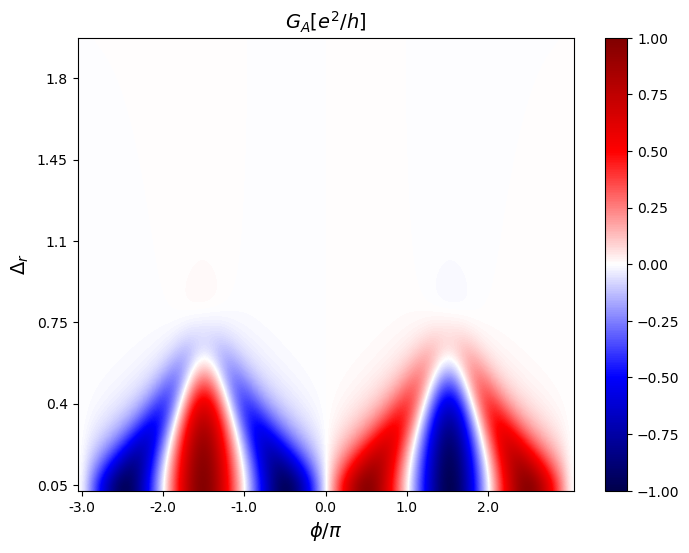

In [ ]:
phi_lab = [i/10 for i in range(-30, 31)]
delta_lab =[i/20 for i in range(1,40)]
plt.figure(figsize=(8,6), dpi=100)
plt.imshow(np.transpose((GA_grid)), aspect = 'auto',origin='lower',interpolation='bicubic', cmap="seismic", vmin=-1, vmax=1)
plt.colorbar()

xtic, labelsx= label_plot(phi_lab)
ytic, labelsy = label_ploty(delta_lab)

plt.ylabel("${\Delta}_r$",fontsize=14)
# plt.title("$G_A[e^2/h]$    (En = "+str(en)+" t,"+" L = "+str(L)+", W = "+str(W)+") and $\Gamma = $"+str(gamma0))
plt.title("$G_A[e^2/h]$", fontsize=14)

plt.xlabel("$\phi/\pi$",fontsize=14)
plt.xticks(xtic, labelsx)
plt.yticks(ytic, labelsy)
# plt.tick_params(axis='both', labelsize=14)
# plt.savefig("/Users/guilhermedelfino/Desktop/GA_heatmap.pdf")
plt.show()

In [11]:
def GAat3pi2(en,gamma0, L,W,Wl):
    # delta_ar =[i/100 for i in range(1,130)]
    # delta_ar =[i/200 for i in range(1,120)]
    delta_ar =[i/1000 for i in range(1,600)]
    size_del = np.array(delta_ar).shape[0]
    flux = 3*pi/2 #+ pi/4
    conduc = np.zeros(size_del)

    for j in range(0,size_del):
        
        delta_el = delta_ar[j]

        conduc[j]= GA(en, L, W, Wl, flux, delta_el, gamma0)
        print(j, " / ", size_del)
        display.clear_output(wait=True)
        # print(W)

    return conduc
    

In [13]:
W=0
Wl=0
L=17
en=0.01

gamma_list =[l/10 for l in range(3,11)]
# Llist = [i for i in range(53, 120, 16)]
gammalistlen = len(gamma_list)
GAvsgamma = [GAat3pi2(en,gamma, L,W,Wl) for gamma in gamma_list ]

598  /  599


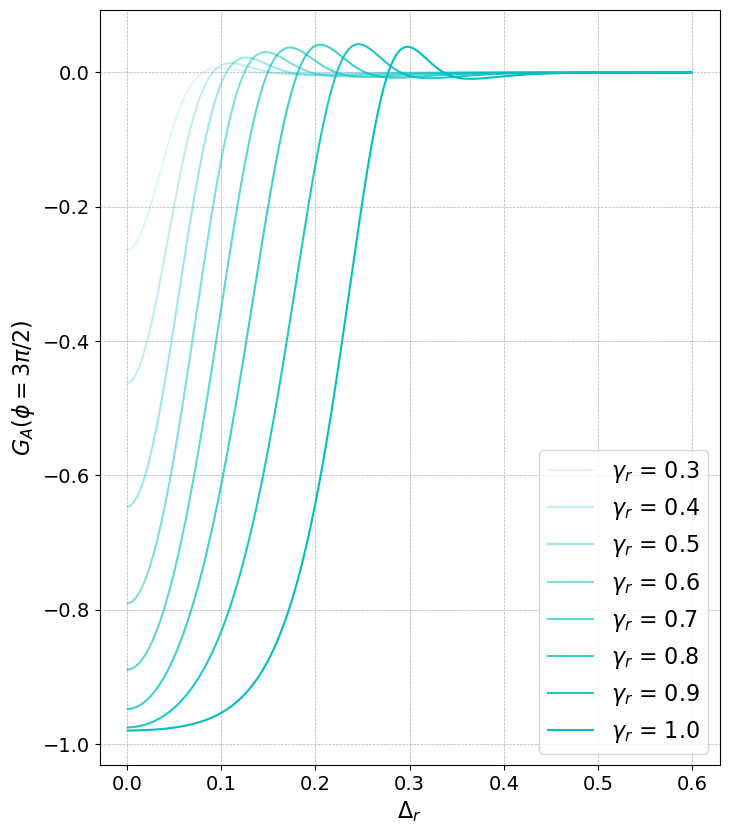

In [16]:
delta_lab =[i/1000 for i in range(1,600)]
threshold=10**(-14)

plt.figure(figsize=(8,10), dpi=100)
for i in range(gammalistlen):

    elem1 = GAvsgamma[i]
    gi = gamma_list[i]
   
    # plt.yscale('log')
    # plt.xscale('log')
    alpha0=  (i+1)/8
    

    plt.plot(np.array(delta_lab),elem1, label = "${\gamma_r}$ = "+str(np.round(gi,2)), linewidth=1.5, alpha = alpha0, color="c")
    plt.legend(loc = 'lower right', prop={'size': 16})
    plt.grid(True,linestyle="--", linewidth=0.5) 
    plt.xlabel("${\Delta_r}$",fontsize=16)
    plt.ylabel("$G_{A}(\phi = 3\pi/2)$",fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    # plt.title("$G_{A}(\phi = 3\pi/2)$ for several values of $\Gamma$ and L="+str(L))
    # plt.title("$G_{A}(\phi = 3\pi/2)$")
    # plt.axhline(y=threshold, linestyle='dotted')

plt.savefig("/Users/guilhermedelfino/Desktop/report/GAat3pi2vsGamma.pdf")


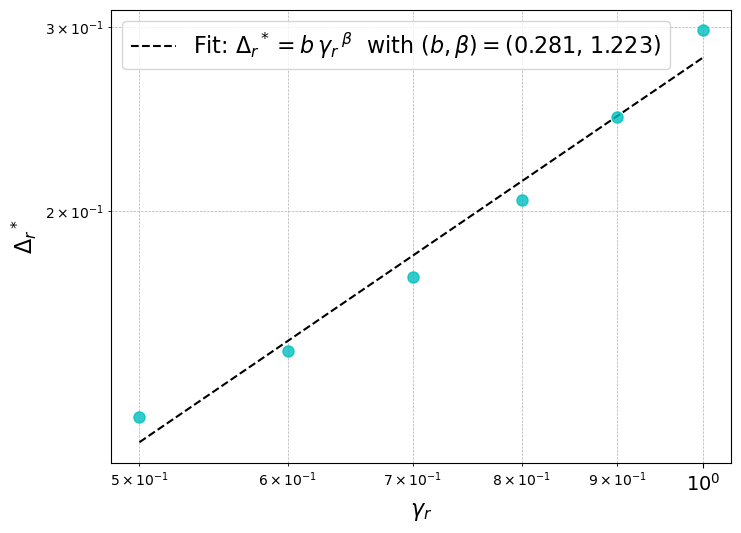

In [ ]:
delta_ar =[i/1000 for i in range(1,600)]

deltamin_ar = []
GA_min=[]

GA_max=[]
deltamax_ar=[]

for i in range(2, gammalistlen):
    elem = GAvsgamma[i]
    size_elem=len(elem)
    GA_m=0
    GA_max_elem=0
    deltamin=0

    # elem_scaled = np.array(elem)/elem[0]
    GA_max_elem = elem.max()#elem_scaled.min()
    max_loc=np.where(elem == GA_max_elem)[0][0]
    deltamax = delta_ar[max_loc]
    deltamax_ar.append(deltamax)

    for j in range(size_elem):

        if np.abs(elem[j])<10**(-14): #Treshold
            GA_m = elem[j]
            deltamin = delta_ar[j]
            break


    gi = gamma_list[i]

    deltamin_ar.append(deltamin)
    GA_min.append(GA_m)

x=np.log(gamma_list)[2:]
# y= np.log(deltamin_ar)
y= np.log(deltamax_ar)
m, c = np.polyfit(x,y, 1)
y_fit = m * x + c

plt.figure(figsize=(8,6), dpi=100)

plt.yscale('log')
plt.xscale('log')



plt.plot(np.exp(x), np.exp(y_fit), "--", color="k",label=r"Fit: ${\Delta_r} ^* = b\, {\gamma_r}\, ^{\beta}$  with $(b,\beta) = $("+str(np.round(np.exp(c),3))+", "+str(np.round(m,3))+")")
# plt.plot(deltamax_ar, np.e**(y_fit), 'r-', label=f'Fit: y = {m:.2f}x + {c:.2f}')
plt.plot(np.exp(x), (deltamax_ar), " ",color="c", marker="o", alpha=0.8, markersize=8)
plt.legend(prop={'size': 16})



plt.xlabel("${\gamma_r}$", fontsize=16)
plt.ylabel("${\Delta_r} ^*$",fontsize=16)
# plt.title("$\Delta^* \,\,  | \, \,\,  d G_A(\phi = 3 \pi/2)=0$", fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
# plt.savefig("/Users/guilhermedelfino/Desktop/deltaL.pdf")
# plt.savefig("/Users/guilhermedelfino/Desktop/report/deltavsGamma.pdf")
plt.show()

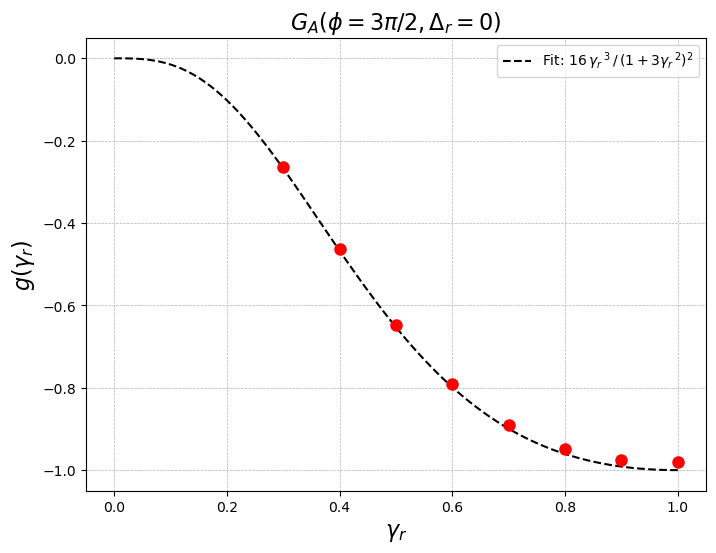

In [ ]:
delta_ar =[i/100 for i in range(1,200)]

Gzero=[]


for i in range(gammalistlen):
    elem = GAvsgamma[i]
    size_elem=len(elem)

    G0_elem=elem[0]

    
    Gzero.append(G0_elem)

# x=np.log(gamma_list)
# # y= np.log(deltamin_ar)
# y= np.log(Gzero)
# m, c = np.polyfit(x,y, 1)
# y_fit = m * x + c

plt.figure(figsize=(8,6), dpi=100)

# plt.yscale('log')
# plt.xscale('log')
gamma_list0 =np.array([l/6 for l in range(0,7)])



x = np.array([i/100 for i in range(101)])
y_junction = -(63.9976*(2*x)**3)/(32 + 47.9976*(2*x)**2 + 18*(2*x)**4)
plt.plot(x,y_junction, "--",color="k", linewidth = 1.5 ,label="Fit: $16\,{\gamma_r}\, ^3\, /\, (1+3 {\gamma_r}\, ^2)^2 $")#From Y-junction paper

plt.plot(gamma_list, (Gzero), " ",color="r", marker="o", markersize=8)

plt.legend()



plt.xlabel("${\gamma_r}$", fontsize=16)
plt.ylabel("$g({\gamma_r})$",fontsize=16)
plt.title("$G_A (\phi = 3\pi/2, {\Delta_r} = 0)$",fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
# plt.savefig("/Users/guilhermedelfino/Desktop/report/ggammat.pdf")
plt.show()

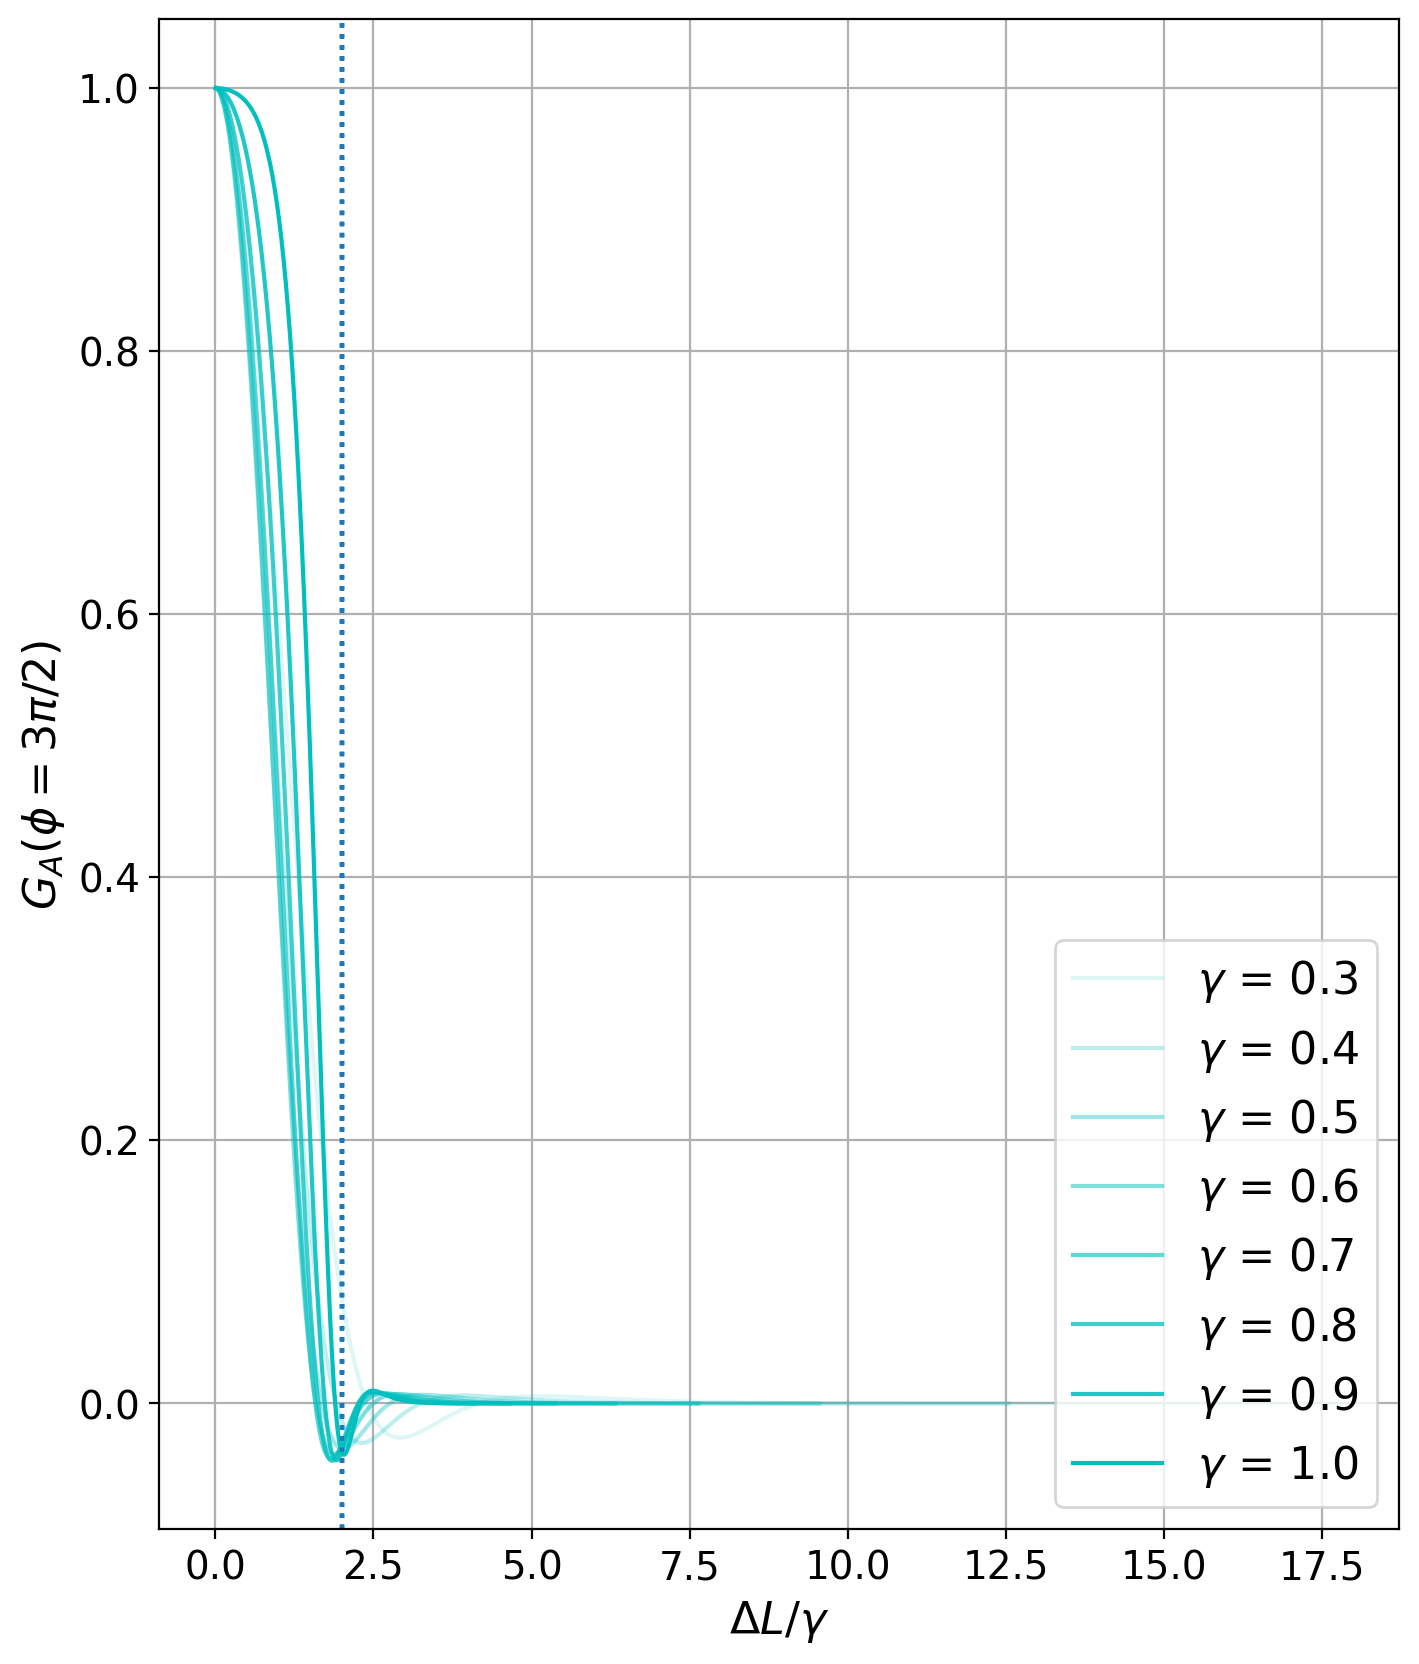

In [16]:
delta_lab =[i/1000 for i in range(1,600)]
threshold=10**(-14)

plt.figure(figsize=(8,10), dpi=200)
for i in range(gammalistlen):

    elem1 = GAvsgamma[i]
    gi = gamma_list[i]
   
    # plt.yscale('log')
    # plt.xscale('log')
    alpha0=  (i+1)/8
    

    plt.plot(np.array(delta_lab)*17**0.678/gi**1.223,(elem1)/elem1[0], label = "$\gamma$ = "+str(np.round(gi,2)), linewidth=1.5, alpha = alpha0, color="c")
    plt.legend(loc = 'lower right', prop={'size': 16})
    plt.grid(True) 
    plt.xlabel("$\Delta L/ \gamma$",fontsize=16)
    plt.ylabel("$G_{A}(\phi = 3\pi/2)$",fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    plt.axvline(x=2, linestyle="dotted")
    # plt.title("$G_{A}(\phi = 3\pi/2)$ for several values of $\Gamma$ and L="+str(L))
    # plt.title("$G_{A}(\phi = 3\pi/2)$")
    # plt.axhline(y=threshold, linestyle='dotted')

# plt.savefig("/Users/guilhermedelfino/Desktop/GAat3pi2vsGamma.pdf")


In [23]:
W=0
Wl=0
en=0.01

g_list =[0.4, 0.7, 1.0]
l_list = [17,21, 25]
GAvsLgamma=[]
Lgamma=[]

for j in range(3):
    for i in range(3):
        Li = l_list[i]
        Gj = g_list[j]
        Lgamma.append((Li,Gj))
        GAvsLgamma.append(GAat3pi2(en,Gj, Li,W,Wl))

598  /  599


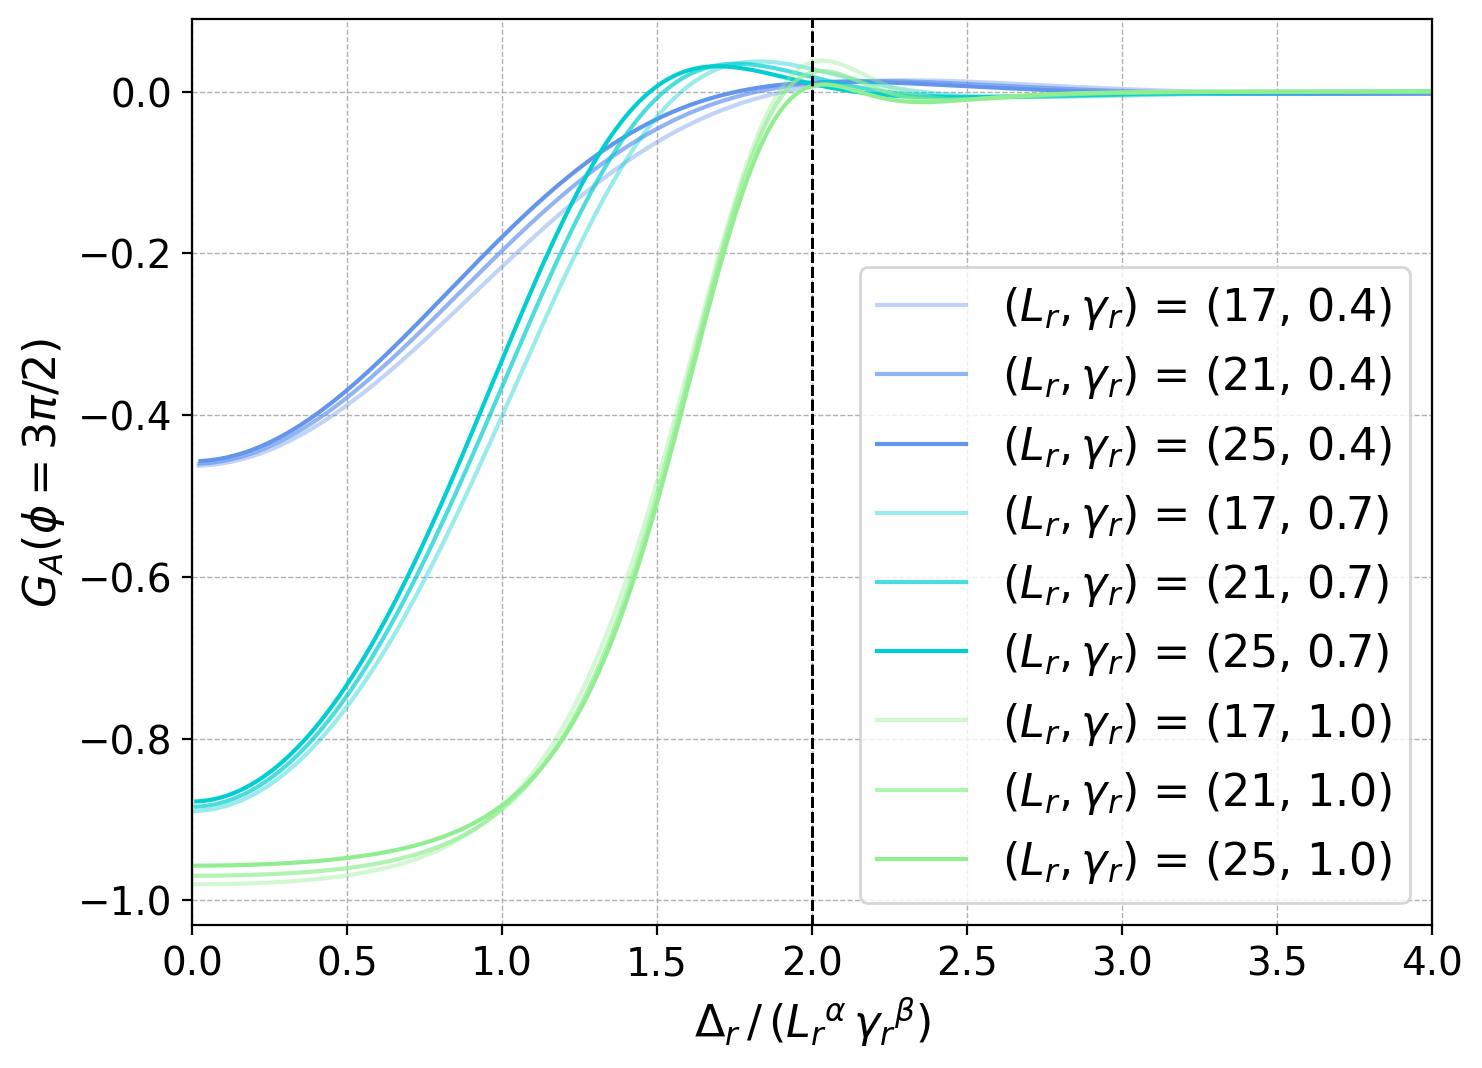

In [26]:
delta_lab =[i/1000 for i in range(1,600)]

plt.figure(figsize=(8,6), dpi=200)

for k in range(9):
    c0=''
    elem = GAvsLgamma[k]
    Li, Gj = Lgamma[k]
   
    # plt.yscale('log')
    # plt.xscale('log')
    # alpha0=  (i+1)/8
    if Gj==0.4:
        c0='cornflowerblue'
    if Gj==0.7:
        c0='darkturquoise'
    if Gj==1.0:
        c0='lightgreen'
    
    if Li==17:
        alpha0=0.4
    if Li==21:
        alpha0=0.7
    if Li==25:
        alpha0=1.0

    
    

    plt.plot(np.array(delta_lab)*(Li**0.678)/(Gj**1.223),elem, label = "$({L_r},{\gamma_r})$ = ("+str(Li)+", "+str(np.round(Gj,2))+")", linewidth=1.5, color=c0, alpha=alpha0)
    plt.legend(loc = 'lower right', prop={'size': 16})
    plt.grid(True, linestyle="--", linewidth=0.5) 
    plt.xlabel(r"${\Delta_r} \, /\, ({L_r} ^{\alpha}\,  {\gamma_r} ^{\beta})$",fontsize=16)
    plt.ylabel("$G_{A}(\phi = 3\pi/2)$",fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    plt.axvline(x=2, linestyle="--", color="k",linewidth=1.0)
    plt.xlim(0, 4)

    # plt.title("$G_{A}(\phi = 3\pi/2)$ for several values of $\Gamma$ and L="+str(L))
    # plt.title("$G_{A}(\phi = 3\pi/2)$")
    # plt.axhline(y=threshold, linestyle='dotted')

plt.savefig("/Users/guilhermedelfino/Desktop/report/GAat3pi2several_Lgamma.pdf")


## Exponential Tail


In [27]:
def GAat3pi2(en,gamma0, L,W,Wl):
    # delta_ar =[i/100 for i in range(1,130)]
    # delta_ar =[i/200 for i in range(1,120)]
    delta_ar =[i/1000 for i in range(1000,2000)]
    size_del = np.array(delta_ar).shape[0]
    flux = 3*pi/2 #+ pi/4
    conduc = np.zeros(size_del)

    for j in range(0,size_del):
        
        delta_el = delta_ar[j]

        conduc[j]= GA(en, L, W, Wl, flux, delta_el, gamma0)
        print(j, " / ", size_del)
        display.clear_output(wait=True)
        # print(W)

    return conduc
    
    
W=0
Wl=0
L=17
en=0.01

gamma_list =[l/10 for l in range(3,11)]
# Llist = [i for i in range(53, 120, 16)]
gammalistlen = len(gamma_list)
GAvsgamma1 = [GAat3pi2(en,gamma, L,W,Wl) for gamma in gamma_list ]

999  /  1000


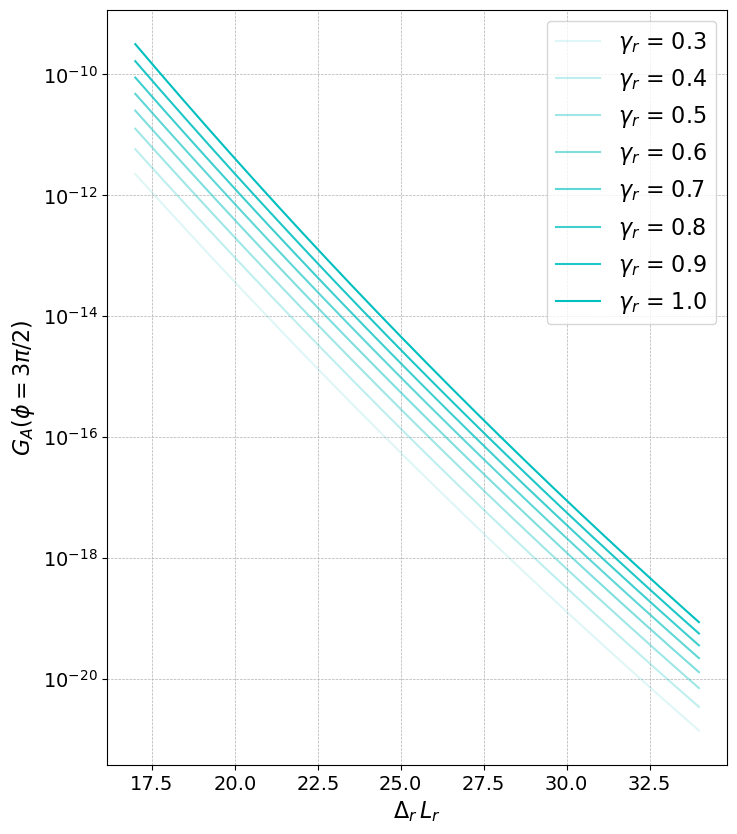

In [30]:
delta_lab =[i/1000 for i in range(1000,2000)]
threshold=10**(-14)

plt.figure(figsize=(8,10), dpi=100)
for i in range(gammalistlen):

    elem1 = GAvsgamma1[i]
    gi = gamma_list[i]
   
    plt.yscale('log')
    # plt.xscale('log')
    alpha0=  (i+1)/8
    

    plt.plot(np.array(delta_lab)*L,np.abs(elem1), label = "${\gamma_r}$ = "+str(np.round(gi,2)), linewidth=1.5, alpha = alpha0, color="c")
    plt.legend(loc = 'upper right', prop={'size': 16})
    plt.grid(True,linestyle="--", linewidth=0.5) 
    plt.xlabel("${\Delta_r}\, {L_r}$",fontsize=16)
    plt.ylabel("$G_{A}(\phi = 3\pi/2)$",fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    # plt.title("$G_{A}(\phi = 3\pi/2)$ for several values of $\Gamma$ and L="+str(L))
    # plt.title("$G_{A}(\phi = 3\pi/2)$")
    # plt.axhline(y=threshold, linestyle='dotted')

plt.savefig("/Users/guilhermedelfino/Desktop/report/GAat3pi2vsGamma_exp_tail.pdf")
